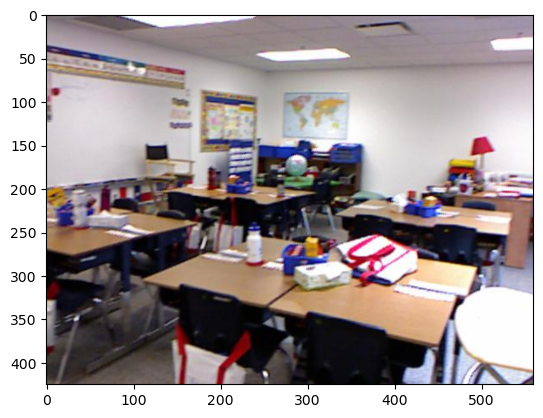

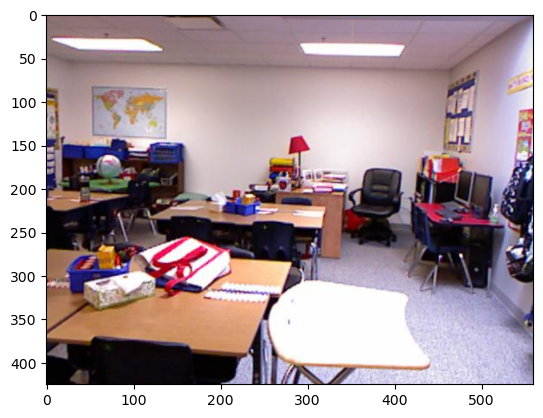

In [1]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

img1 = Image.open('../images/a1.png')
img2 = Image.open('../images/a2.png')#.resize(img1.size)

timg1 = kornia.utils.image_to_tensor(np.array(img1), False).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(img2), False).float() / 255.

timg = torch.cat([timg1,timg2], dim=0)

timg_gray = kornia.color.rgb_to_grayscale(timg)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

In [2]:
#Lets define some functions for local feature matching

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return


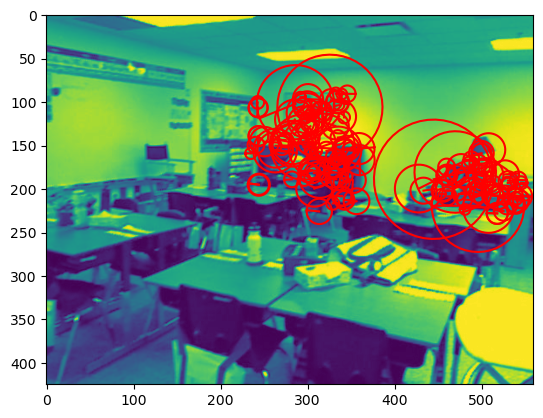

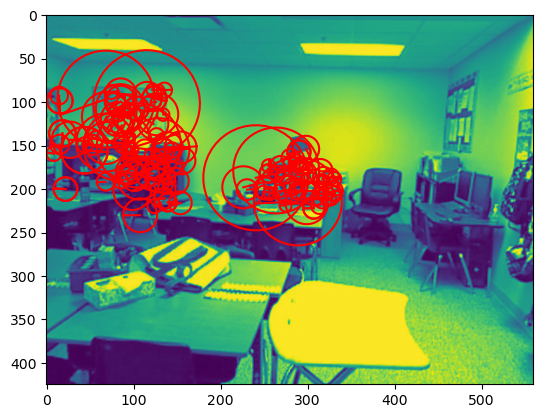

147 inliers


In [3]:
#Now lets define local deature detector and descriptor

device = torch.device('cpu')
#device = torch.device('cuda:0')

PS = 41

sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift

resp = BlobHessian()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)

nms = kornia.geometry.ConvQuadInterp3d(10)

n_features = 4000
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(19),
                              mr_size=6.0).to(device)

with torch.no_grad():
    lafs, resps = detector(timg_gray)
    patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, lafs, PS)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)

# Now RANSAC
src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)

inliers = matches[torch.from_numpy(mask).bool().squeeze(), :]

for i in range(2):
    visualize_LAF(timg_gray, lafs[:,inliers[:,i]], i)
print (len(inliers), 'inliers')

/var/folders/xl/510yskh50hj_222x1q55k8_c0000gn/T/ipykernel_39492/612073695.py:22: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(19),


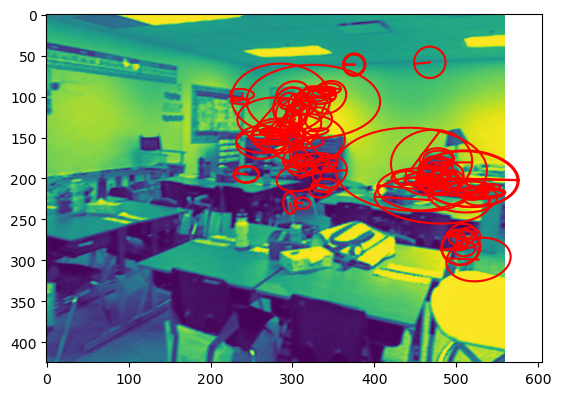

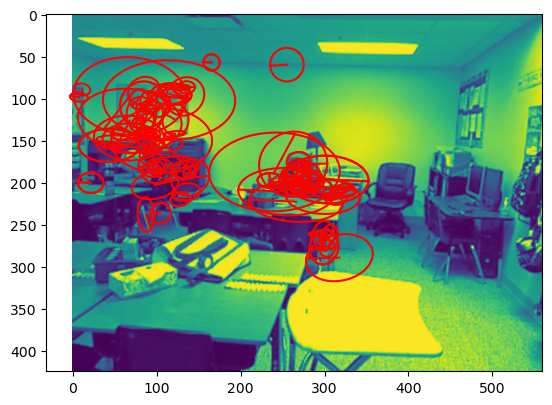

109 inliers


In [4]:
#Now lets define  affine local deature detector and descriptor

device = torch.device('cpu')
#device = torch.device('cuda:0')

PS = 41

sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift

resp = BlobHessian()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)

nms = kornia.geometry.ConvQuadInterp3d(10)

n_features = 4000
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(19),
                              aff_module=kornia.feature.LAFAffineShapeEstimator(19),
                              mr_size=6.0).to(device)

with torch.no_grad():
    lafs, resps = detector(timg_gray)
    patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, lafs, PS)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)

# Now RANSAC
src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)

inliers = matches[torch.from_numpy(mask).bool().squeeze(), :]

for i in range(2):
    visualize_LAF(timg_gray, lafs[:,inliers[:,i]], i)
print (len(inliers), 'inliers')


Downloading: "https://github.com/ducha-aiki/affnet/raw/master/pretrained/AffNet.pth" to /Users/liu/.cache/torch/hub/checkpoints/AffNet.pth
100.0%
/var/folders/xl/510yskh50hj_222x1q55k8_c0000gn/T/ipykernel_39492/519401866.py:22: DeprecationWarning: `LAFAffNetShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffNetShapeEstimator(True),


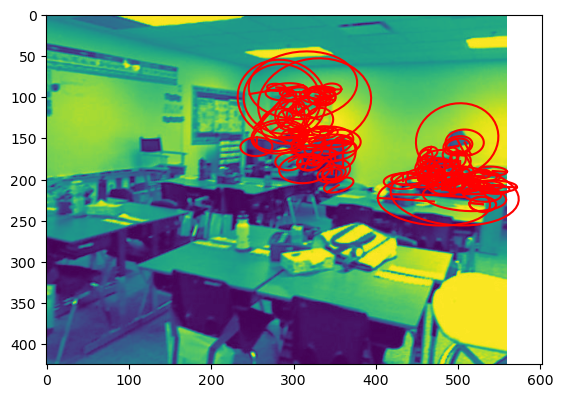

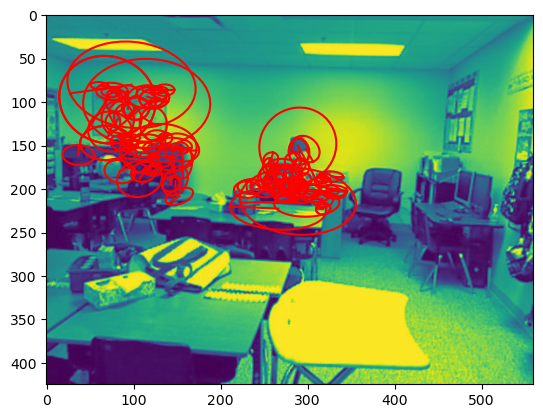

106 inliers


In [6]:
#Now lets define  affine local deature detector and descriptor

device = torch.device('cpu')
#device = torch.device('cuda:0')

PS = 41

sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift

resp = BlobHessian()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)

nms = kornia.geometry.ConvQuadInterp3d(10)

n_features = 4000
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(19),
                              aff_module=kornia.feature.LAFAffNetShapeEstimator(True),
                              #kornia.feature.LAFAffNetShapeEstimator(True),
                              mr_size=6.0).to(device)

with torch.no_grad():
    lafs, resps = detector(timg_gray)
    patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, lafs, PS)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)

# Now RANSAC
src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)

inliers = matches[torch.from_numpy(mask).bool().squeeze(), :]

for i in range(2):
    visualize_LAF(timg_gray, lafs[:,inliers[:,i]], i)
print (len(inliers), 'inliers')


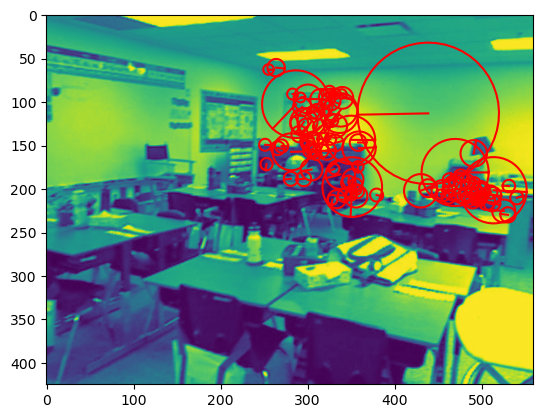

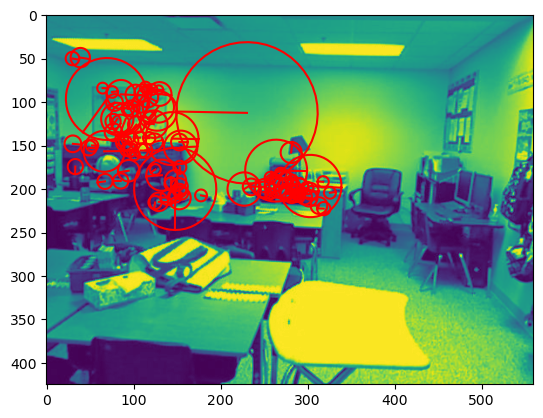

101 inliers


In [7]:
#Now lets try with Difference-of-Gaussians, aka SIFT keypoints

device = torch.device('cpu')
#device = torch.device('cuda:0')

PS = 41

sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift

resp = BlobDoG()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)

nms = kornia.geometry.ConvQuadInterp3d(10)

n_features = 4000
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              scale_space_response=True,#We need that, because DoG operates on scale-space
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(19),
                              mr_size=6.0,
                              minima_are_also_good=True).to(device) #dark blobs are as good as bright.

with torch.no_grad():
    lafs, resps = detector(timg_gray)
    patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, lafs, PS)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)

# Now RANSAC
src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)

inliers = matches[torch.from_numpy(mask).bool().squeeze(), :]

for i in range(2):
    visualize_LAF(timg_gray, lafs[:,inliers[:,i]], i)
print (len(inliers), 'inliers')
